In [1]:
using Pkg; Pkg.activate()

  Activating project at `~/.julia/environments/v1.11`


In [2]:
using Revise

In [3]:
using Distributions
using DataStructures
using DensityInterface
using Newtrinos

In [58]:
Revise.revise(Newtrinos)

[ Info: (cuinit = HeterogeneousComputing.CPUnit(), precision = Float64, rng = Random123.Philox4x{UInt64, 10}(0x9c0c993734156b1e, 0xe76a95b6fbb3ad08, 0x10e0683565cb2610, 0x28ecbab705d74162, 0x3450fb642d70f5fd, 0x7a5e22ca7f7db8f1, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0), ad = ADTypes.AutoZygote())
┌ Warning: Replacing docs for `Newtrinos.find_mle :: Tuple{Any, Any, Any}` in module `Newtrinos`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Newtrinos.profile :: NTuple{4, Any}` in module `Newtrinos`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Newtrinos.scan :: NTuple{4, Any}` in module `Newtrinos`
└ @ Base.Docs docs/Docs.jl:243


true

In [6]:
osc = Newtrinos.osc.standard

Newtrinos.osc.standard

In [68]:
modules = [Newtrinos.dayabay]

1-element Vector{Module}:
 Newtrinos.dayabay

In [69]:
param_dict = merge(osc.params, [m.params for m in modules]...)
prior_dict = merge(osc.priors, [m.priors for m in modules]...)

OrderedDict{Any, Any} with 6 entries:
  :θ₁₂   => Uniform{Float64}(a=0.420534, b=0.785398)
  :θ₁₃   => Uniform{Float64}(a=0.1, b=0.2)
  :θ₂₃   => Uniform{Float64}(a=0.523599, b=1.0472)
  :δCP   => Uniform{Float64}(a=0.0, b=6.28319)
  :Δm²₂₁ => Uniform{Float64}(a=6.5e-5, b=9.0e-5)
  :Δm²₃₁ => Uniform{Float64}(a=0.002, b=0.003)

In [70]:
data = [m.observed for m in modules]

1-element Vector{Vector{Float64}}:
 [18388.160000000003, 24005.38, 33680.240000000005, 41465.35, 47637.770000000004, 52942.16, 54914.549999999996, 55474.310000000005, 54295.79, 51504.69  …  23443.870000000003, 18945.02, 15003.310000000001, 11523.35, 8862.91, 6213.89, 4414.6900000000005, 2892.5299999999997, 1834.24, 2128.56]

In [11]:
#data = [mean(m.forward_model(osc.osc_prob)(NamedTuple(param_dict))) for m in modules]

In [71]:
llh = Newtrinos.generate_likelihood(modules, osc, data)

LogFuncDensity(Newtrinos.var"#155#159"{Vector{Newtrinos.var"#154#158"{Int64, typeof(Newtrinos.osc.standard.osc_prob), Vector{Float64}, Vector{Module}}}}(Newtrinos.var"#154#158"{Int64, typeof(Newtrinos.osc.standard.osc_prob), Vector{Float64}, Vector{Module}}[Newtrinos.var"#154#158"{Int64, typeof(Newtrinos.osc.standard.osc_prob), Vector{Float64}, Vector{Module}}(1, Newtrinos.osc.standard.osc_prob, [18388.160000000003, 24005.38, 33680.240000000005, 41465.35, 47637.770000000004, 52942.16, 54914.549999999996, 55474.310000000005, 54295.79, 51504.69  …  23443.870000000003, 18945.02, 15003.310000000001, 11523.35, 8862.91, 6213.89, 4414.6900000000005, 2892.5299999999997, 1834.24, 2128.56], Module[Newtrinos.dayabay])]))

In [161]:
prior_dict[:θ₁₃] = Uniform(0.135, 0.16)
#prior_dict[:Δm²₃₁] = Uniform(0.00225, 0.0028)
prior_dict[:Δm²₃₁] = Uniform(-0.003, 0.003)

Uniform{Float64}(a=-0.003, b=0.003)

In [162]:
for var in [:θ₁₂, :δCP, :Δm²₂₁, :θ₂₃]
    prior_dict[var] = param_dict[var]
end

In [163]:
prior_dict

OrderedDict{Any, Any} with 6 entries:
  :θ₁₂   => 0.587252
  :θ₁₃   => Uniform{Float64}(a=0.135, b=0.16)
  :θ₂₃   => 0.855629
  :δCP   => 1.0
  :Δm²₂₁ => 7.53e-5
  :Δm²₃₁ => Uniform{Float64}(a=-0.003, b=0.003)

In [164]:
vars_to_scan = (θ₁₃ = 100, Δm²₃₁ = 100)

(θ₁₃ = 100, Δm²₃₁ = 100)

In [165]:
result = Newtrinos.profile(llh, prior_dict, vars_to_scan, param_dict);

In [59]:
using CairoMakie

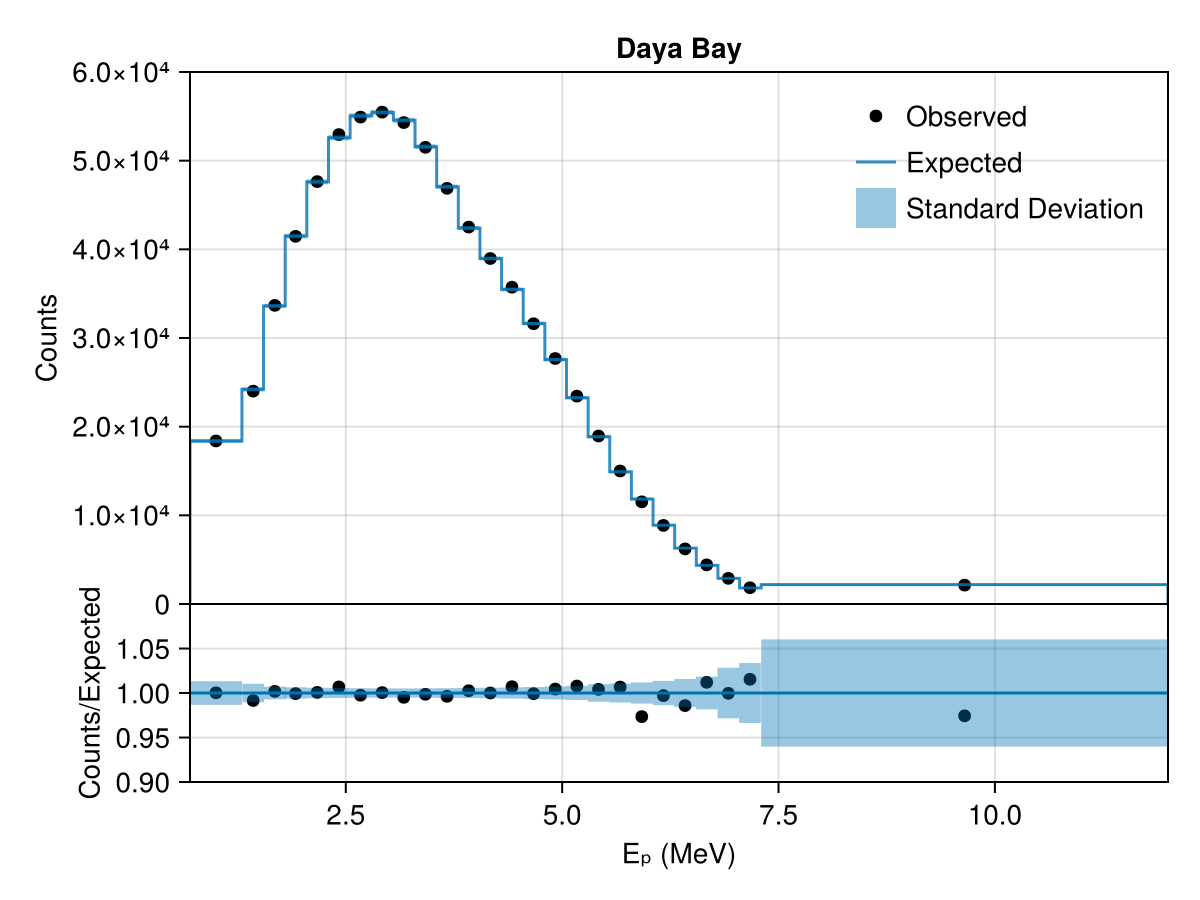

In [159]:
Newtrinos.dayabay.plot(Newtrinos.bestfit(result), osc.osc_prob, data[1])

In [21]:
using DataFrames
using DelimitedFiles

In [88]:
df = DataFrame(readdlm("DayaBay_DeltaChiSq_NO_3158days.txt", skipstart=9,), :auto)
rename!(df, [:sin2theta13, :dm232, :deltachi2]);

In [153]:
sh = (100, 100)

ax = (θ₁₃=0.5 .* asin.(sqrt.(reshape(df.sin2theta13, sh)[1,:])),
      Δm²₃₁=reshape(df.dm232, sh)[:,1] .+ 7.53e-5,)

chi2 = reshape(df.deltachi2, sh)';

In [154]:
official = NewtrinosResult(axes=ax, values = (log_posterior =  -0.5 .*chi2,));

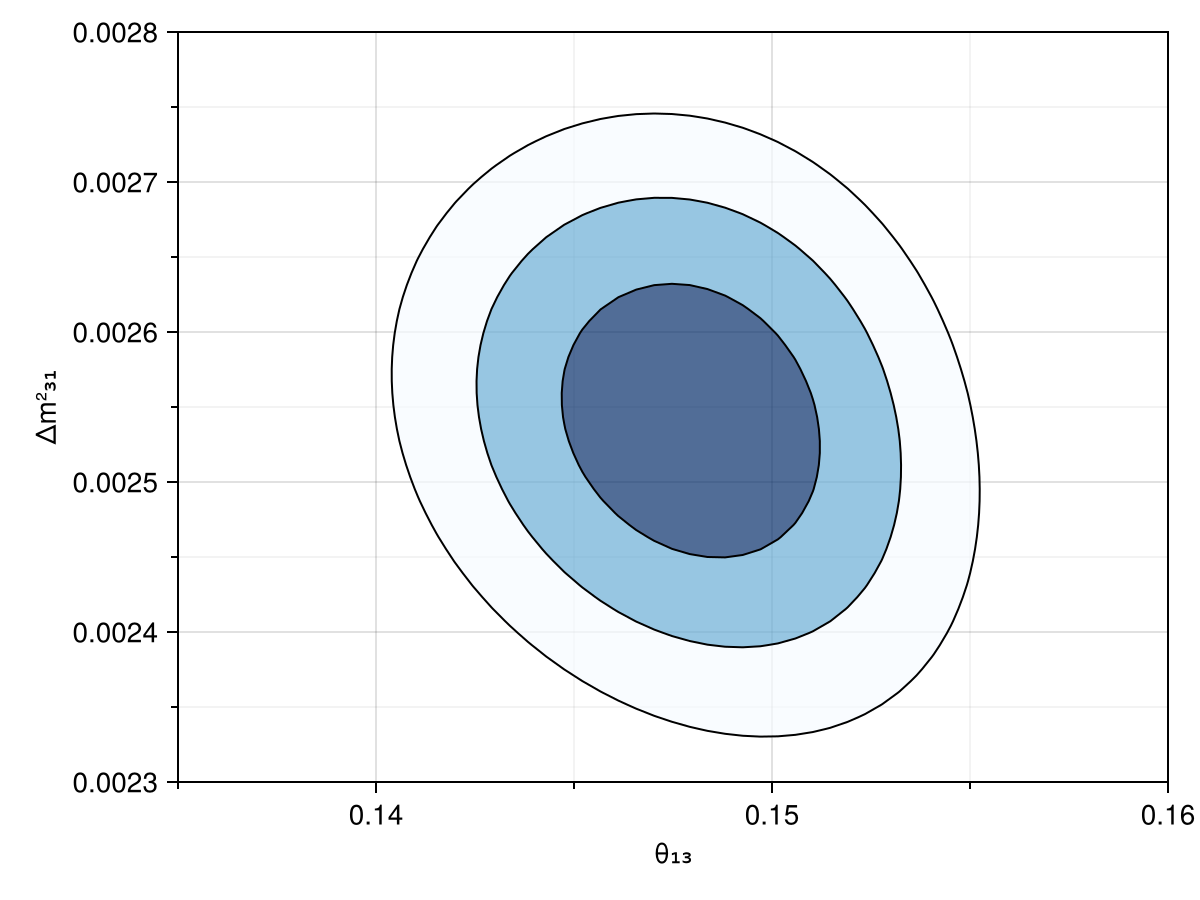

In [155]:
f = plot(official)
ax = f.content[1]
xlims!(ax, 0.135, 0.16)
ylims!(ax, 2.3e-3, 2.8e-3)
f

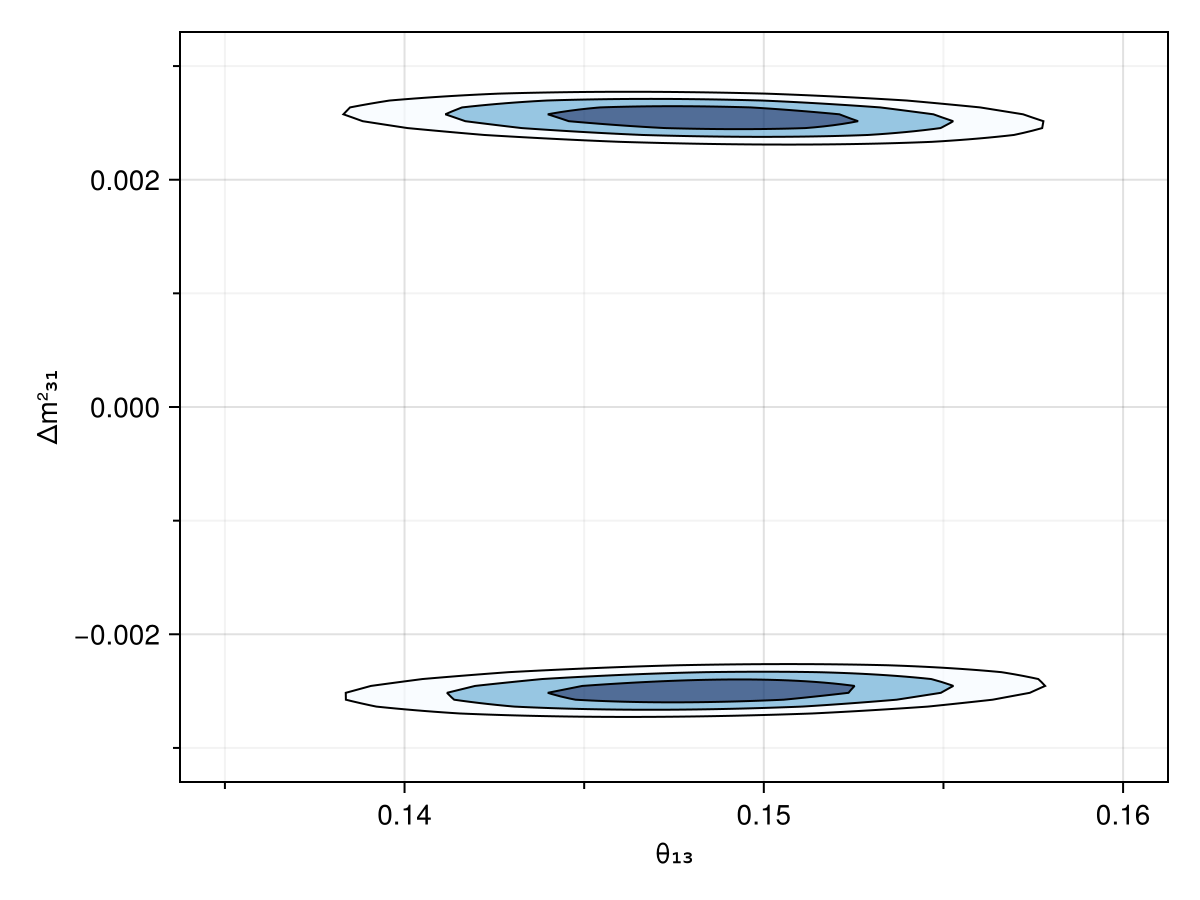

In [167]:
f = plot(result)
ax = f.content[1]
#xlims!(ax, 0.135, 0.16)
#ylims!(ax, 2.3e-3, 2.8e-3)
f